# Week 7
## Modeling outbreak dynamics
In this week we will look at modeling a different sort of phenomenon, one that is near and dear to our hearts-- epidemiological outbreaks. In particular we will take a tour through some of the classic epidemiological population biology models, we will simulate from them, and we (Eventually) will try to estimate numbers from them from real data.

The epidemiological models we will look at play an important role in understanding and managing the transmission dynamics of various pathogens including viruses. We can use them to describe the spatial and temporal patterns of disease prevalence, as well as to explore or better understand the factors that shape infection rates. Modeling is a key step in understanding what treatments and interventions can be most effective, how cost-effective these approaches may be, and what specific factors need to be considered when trying to eradicate disease.


## Compartment models
The vast majority of epi models are so-called "compartment" models, in which we assume individuals move through different phases of the infection processes and thus can be categorized into simple classes or compartments. These are the models that you see flooding the newpapers and internet these days. 

<img src=imgs/generic_infection.png>

Traditionally these models are written (and solved) as differential equations, just as we had looked at with our exponential population growth model. Because they are expressed as differential equations, compartment models are generally _deterministic_ models, meaning there is no randomness at all in the model. We will look at these solutions as well as add stochasticity back into our models using similar techniques to what we did when we studied genetic drift.

## The SI model
The SI model is the simplest form of all epi models. Individuals are born into the simulation with no immunity (susceptible). Once infected and with no treatment, individuals stay infected and infectious throughout their life, and remain in contact with the susceptible population. This model matches the behavior of diseases like chickenpox or herpes. The SI of course stands for the two compartments of the model Susceptible (S) and Infectious (I).

To parameterize this model we need a bit of notation. Let's call $N$ the total number of individuals in the population and some time, $I$ the number of infectious individuals in the population at some time, and $S$ the number of susceptible (uninfected) individuals in the population such that $N = S + I $. 

In the SI model we need to now introduce one more parameter $\beta$ which represents the rate of conversion of individuals from susceptible to infectious. $\beta$ can also be thought of as the average number of individuals that an infectious individual converts, but more on that later. Having defined this the SI model is quite simple in it's dynamic-- all individuals will eventually move from the S to the I compartment and never return (individuals are immune for the remainder of their lives). You'll notice that these equations will look quite a lot like exponential growth as a result. Graphically here is what the model looks like

<img src=imgs/SI_model.png alt="drawing" width="350"/>

now let's write down the mathematical form of this model, again using differential equations

$$
\begin{align}
\frac{\partial S}{\partial t} &= -\frac{\beta S I}{ N} \\
\frac{\partial I}{\partial t} &= \frac{\beta S I}{ N}  \\
\end{align}
$$




So each generation we can see that the susceptible population is decreasing and the infected population is increasing. 

**Question:** what are the eventual dynamics of the population?

Well it's pretty simple to see from the math-- the S compartment will shrink over time and the I compartment will increase. This is true no matter what the value of $\beta$. Let's plot then solves these differential equations and plot the solution.

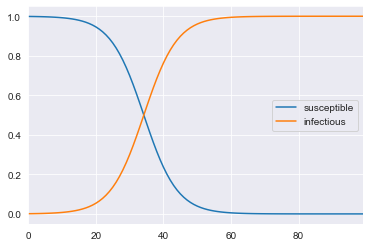

In [18]:
import numpy as np
from scipy.integrate import odeint, quad # we will use this to solve ODE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('darkgrid')
#sns.set(rc={'axes.facecolor':'blanchedalmond'})
                
# Total population, N.
N = 1000
# Initial number of infected and susceptible individuals, I0 and S0.
I0 = 1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 
# Contact rate, beta 
beta = 0.2 
# A grid of time points (in days)
t = np.linspace(0, 100, 100)

# The SI model differential equations.
def SI(y, t, N, beta):
    S, I = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N
    return dSdt, dIdt

# Initial conditions vector
y0 = S0, I0

# Integrate the SI equations over the time grid, t.
# this does the hard work for us
ret = odeint(SI, y0, t, args=(N, beta))
S, I = ret.T / N  # divide through by N to get proportions

df = pd.DataFrame({"susceptible":S, "infectious":I})
df.plot()



so the dynamics are as we were expecting! After time everyone becomes infected! Note that these curves are incredibly smooth with zero noise to them. Ask yourself-- why?

Also note the incredibly similarity between this model and the selection models we studied last week. Both our evolution models last week and the models we will cover this week are _population_ models.

## SIR model
Many pathogenic infections can be fought off by the host, and thus previously infected individuals can recover. To model this situation we might simply add a third compartment to our SI model above, the _recovered_ state, $R$. We call the rate of recovery for infected individuals $\gamma$ and it is usually chosen such that the if the average number of days an individual is sick $d$, $\gamma = 1 / d$.

Let's look at the graphical model-- this is the in my opinion the best way to start thinking in your head about more complex models

<img src=imgs/SIR_model.png alt="drawing" width="400"/>

As you might expect, we now introduce a third differential equation into our system so that our model looks like

$$
\begin{align}
\frac{\partial S}{\partial t} &= -\frac{\beta S I}{ N} \\
\frac{\partial I}{\partial t} &= \frac{\beta S I}{ N} - \gamma I \\
\frac{\partial R}{\partial t} &= \gamma I \\
\end{align}
$$

So a few crucial notes about this model. First this model is a stationary population size model. That is N doesn't change, but the membership between compartments does. This implies that
$$
\frac{\partial S}{\partial t} 
+ \frac{\partial I}{\partial t} 
+ \frac{\partial R}{\partial t} = 0.
$$

Next take a look at the graphical representation of the model above and think about the number of individuals in the Infectious state. That number $I$ is determined by two parameters, $\beta$ and $\gamma$. The ratio of these two parameters has a special importance and a name that's definitely already familiar to you. We say that the basic reproduction number of our pathogen $R_0$ is
$$
R_0 = \frac{\beta}{\gamma}
$$

Let's rewrite our differential equation for the infectious class above, $\frac{\partial I}{\partial t}$ plugging in $R_0$ and gain some insight into the process

$$
\frac{\partial I}{\partial t} = (R_0 \frac{S}{N} - 1)\gamma I
$$

written this way we can see that if 
$$
R_0 > \frac{N}{S}
$$
then 
$$
\frac{\partial I}{\partial t} > 0
$$ 
and the number of infections will grow. Conversely if $R_0 < \frac{N}{S}$ then $\frac{\partial I}{\partial t} < 0$ and the outbreak will not grow in size.  Note that these dynamics are independent of the number of infected or susceptible individuals at the specific time-- if $R_0$ is above the critical threshold it the number of infections just keeps growing. This is why you keep hearing about $R_0$ in the news with respect to COVID-- it's a crucial parameter in our models, even the more elaborate versions of this one.


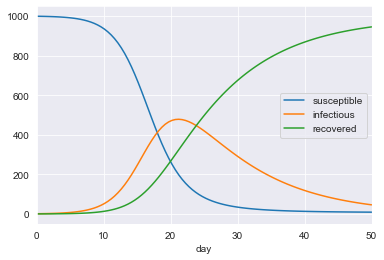

In [7]:
# Total population, N.
N = 1000
# Initial number of infected and susceptible individuals, I0 and R0.
I0 = 1
R0 = 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta 
beta = 0.5 
# recovery rate, gamma
d = 10
gamma = 1 / d

# A grid of time points (in days)

t = np.linspace(0, d*5, 100)

# The SI model differential equations.
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N -  gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SI equations over the time grid, t.
# this does the hard work for us
ret = odeint(SIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T  # divide through by N to get proportions
df = pd.DataFrame({"susceptible":S, "infectious":I, "recovered":R},index=t)
df.index.name="day"
df.plot()

let's play with this but alter the parameters of the model

## Measles
Let's plug in the numbers for measles. According to [this review](https://www.ncbi.nlm.nih.gov/pubmed/28757186) $R_0$ estimates for measles are somewhere between 12 and 18 and infected individuals are contagious for about 8 days, meaning that $\gamma = 1 / 8 = 0.125$ and $\beta$ might equal $\beta = 12 \times 0.125 = 1.5 $. 

Let's say there are 19,000 undergraduates at a university in the Pacific North West, none of whom are vaccinated against measles, and a single individual shows up with measles shows up for Fall term. How might a breakout proceed?

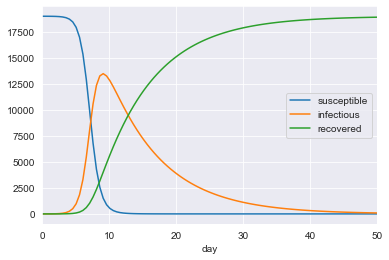

In [15]:
beta = 1.5
gamma = 0.125

N = 19000 # population size
I0 = 1
R0 = 0
S0 = N - I0
y0 = S0, I0, R0

t = np.linspace(0, d*5, 100)
ret = odeint(SIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T  # divide through by N to get proportions
df = pd.DataFrame({"susceptible":S, "infectious":I, "recovered":R},index=t)
df.index.name="day"
df.plot()

measles is an astoundingly transmissible disease-- just look at these dynamics! 10 days after a single infected individual showed up on campus, under SIR dynamics roughly 13,000 individuals would be infected on campus or $\sim 68\%$!

## COVID-19
So for the SARS-CoV-2 virus initial estimates of $R_0$ are approximately in the range of $R_0=2.3$ with an infectious period of about 5 days (i.e. $\gamma = 0.2$). Again let's do the experiment of releasing a single case on campus and let it go crazy

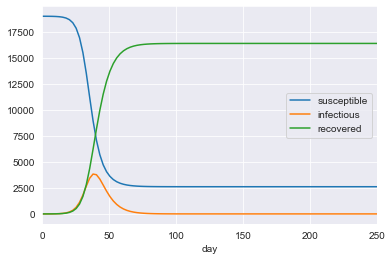

In [17]:
R0 = 2.3
d = 5
gamma = 1 / d
beta = R0 * gamma 

N = 19000 # population size
I0 = 1
R0 = 0
S0 = N - I0
y0 = S0, I0, R0

t = np.linspace(0, d*50, 100)
ret = odeint(SIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T  # divide through by N to get proportions
df = pd.DataFrame({"susceptible":S, "infectious":I, "recovered":R},index=t)
df.index.name="day"
df.plot()

a couple things to note here:
1. SARs-CoV-2 is less infectious than measles. This means that fewer people will become infected were it allowed to burn through the population. However, the number of infected people would still be large on our campus
2. Note that some large portion of the population never becomes infected and thus remains susceptible to the virus. This means that reintroduction of infectious individuals to the area would lead to a new outbreak